In [1]:
import os
import broad_qc as bq

# Constants
METRICS_DB = '/gale/netapp/seq11/illumina_runs/qc_metrics/broad_metrics.db'
METRICS_PATH = '/gale/netapp/seq11/illumina_runs/qc_metrics/'
FILE = 'LP-INNKFJ501544_Broad_QC__SALK080_SALK081__227YY7LT4.csv'

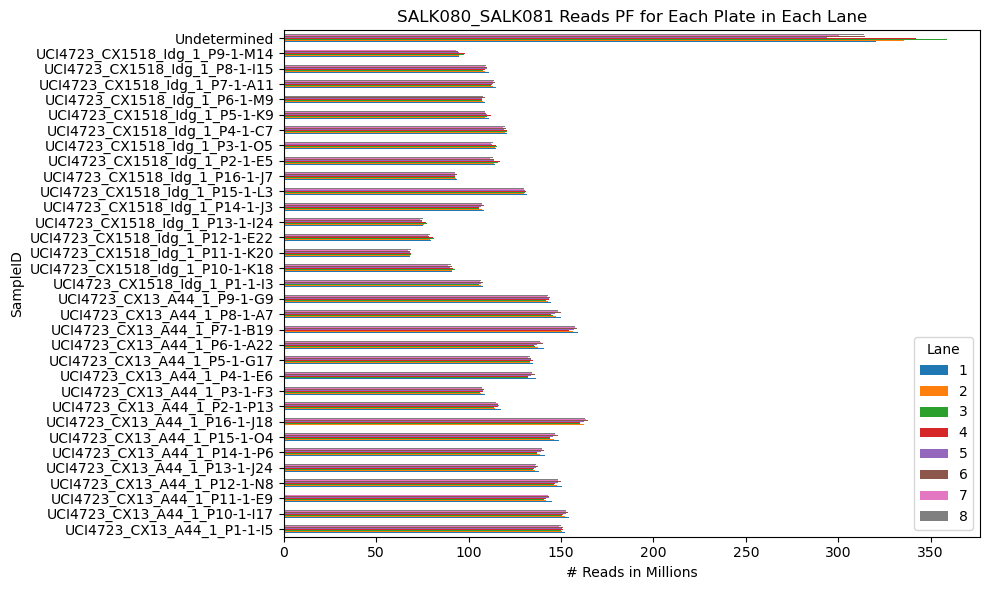

<Figure size 1000x600 with 0 Axes>

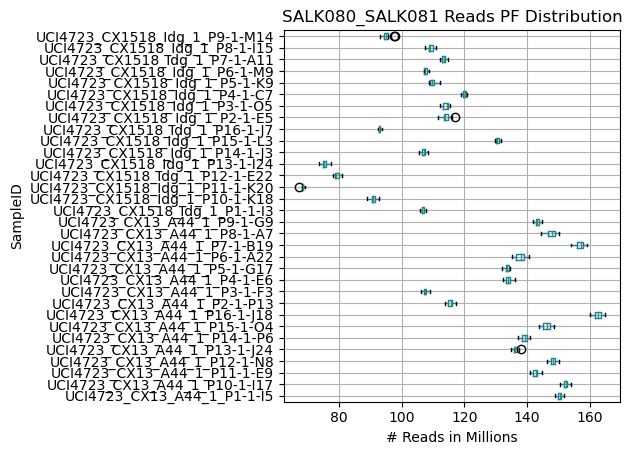

In [2]:
# Get pool strings and files
pool_string, pool_strings = bq.get_pool_strings(FILE)
pool_files = [os.path.join(METRICS_PATH, pool) for pool in pool_strings]

# Read dataframes
file_path = os.path.join(METRICS_PATH, FILE)
demux_stats, top_unknown_barcodes = bq.read_dataframes(file_path)

# Calculate and format metrics
unformatted_metrics = bq.calculate_metrics(demux_stats, top_unknown_barcodes)

formatted_metrics = bq.format_metrics(unformatted_metrics)

# Plot reads vs SampleID reversed
bq.plot_reads_vs_sampleID_reversed(demux_stats, METRICS_PATH, pool_string)


@card Broad sequencing QC metrics accepted
run_yield: 10,370,993,631,167 bases
run_yield_excluding_undetermined: 9,630,190,875,811 bases
total_reads: 33,695,528,683 Reads PF
total_reads_excluding_undetermined: 31,115,852,991 Reads PF
assumed_phiX_reads: 954,450,337 Reads PF
percent_phix_assumed: 2.83%
SALK080 fewest reads in a lane: UCI4723_CX13_A44_1_P3-1-F3: 106,287,950
SALK081 fewest reads in a lane: UCI4723_CX1518_Idg_1_P11-1-K20: 67,252,931
SALK080 Percentage of Run: 57.96%, 18,035,587,773 Reads PF
SALK081 Percentage of Run: 42.04%, 13,080,265,218 Reads PF


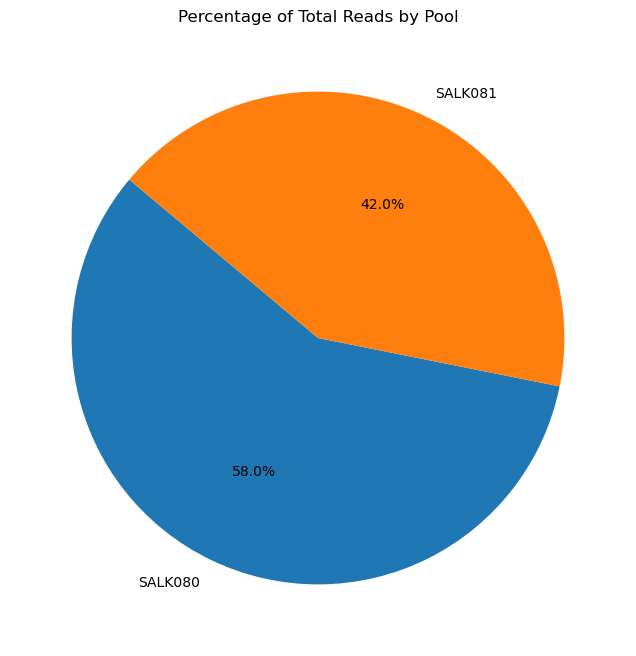

In [4]:
# Extract samples from files
pools = bq.extract_samples_from_files(demux_stats, pool_files)

# Initialize list for all formatted metrics
unformatted_metrics_list = []
formatted_metrics_list = []

for file_path, pool in pools.items():
    pool_metrics = bq.calculate_metrics(pool, top_unknown_barcodes)
    formatted_pool_metrics = bq.format_metrics(pool_metrics)
    unformatted_metrics_list.append(pool_metrics)
    formatted_metrics_list.append(formatted_pool_metrics)

print("@card Broad sequencing QC metrics accepted")
for key, value in formatted_metrics.items():
    if key != "plate_with_fewest_reads_in_a_lane":
        print(f"{key}: {value}")
        
# Print pool metrics 
for pool, metrics in zip(pool_strings, formatted_metrics_list):
    print(f"{pool} fewest reads in a lane: {metrics.get('plate_with_fewest_reads_in_a_lane')}")

# Initialize variables before the loop
pool_total_reads = []
total_reads_sum = 0

# Iterate through pool_strings and formatted_metrics_list simultaneously
for pool, metrics in zip(pool_strings, unformatted_metrics_list):
    # Extract numeric value from 'total_reads' in metrics
    total_reads = metrics.get('total_reads')
    # Append the total reads to pool_total_reads
    pool_total_reads.append(total_reads)
    
    # Add to the total sum of reads
    total_reads_sum += total_reads

import matplotlib.pyplot as plt

# Initialize lists for labels and percentages
labels = []
percentages = []

# Calculate percentages and gather labels and percentages
for pool, total_reads in zip(pool_strings, pool_total_reads):
    percentage = (total_reads / total_reads_sum) * 100
    labels.append(pool)
    percentages.append(percentage)
    print(f"{pool} Percentage of Run: {percentage:.2f}%, {total_reads:,} Reads PF")

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Total Reads by Pool')

# Save the plot
filename = "_".join(pool_strings) + "_percentage.png"
filepath = os.path.join(METRICS_PATH, filename)
plt.savefig(filepath)

In [ ]:
# Write to database and print confirmation
bq.write_to_broad_metrics_db(pool_strings, unformatted_metrics_list, METRICS_DB)

# Query the database
bq.query_database(METRICS_DB)